In [1]:
from dataclasses import dataclass
import time
import optax
import genjax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
from genjax import grasp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

In [2]:
@genjax.gen
def top_model(θ):
    x = genjax.tfp_normal(jnp.cos(θ), 0.2) @ "x"
    y = genjax.tfp_normal(jnp.sin(θ), 0.2) @ "y"
    return (x, y)


@genjax.gen
def bottom_model(θ):
    x = genjax.tfp_normal(1 - jnp.cos(θ), 0.2) @ "x"
    y = genjax.tfp_normal(1 - jnp.sin(θ) - 0.8, 0.2) @ "y"
    return (x, y)

In [3]:
key, sub_key = jax.random.split(key)
theta_range = jnp.arange(0.0, jnp.pi, step=1 / 3600)
sub_keys = jax.random.split(sub_key, len(theta_range))
tr = jax.jit(jax.vmap(top_model.simulate))(sub_keys, (theta_range,))
top_chm = tr.strip()
print(len(theta_range))

11310


In [4]:
key, sub_key = jax.random.split(key)
theta_range = jnp.arange(0.0, jnp.pi, step=1 / 3600)
sub_keys = jax.random.split(sub_key, len(theta_range))
tr = jax.jit(jax.vmap(bottom_model.simulate))(sub_keys, (theta_range,))
bottom_chm = tr.strip()

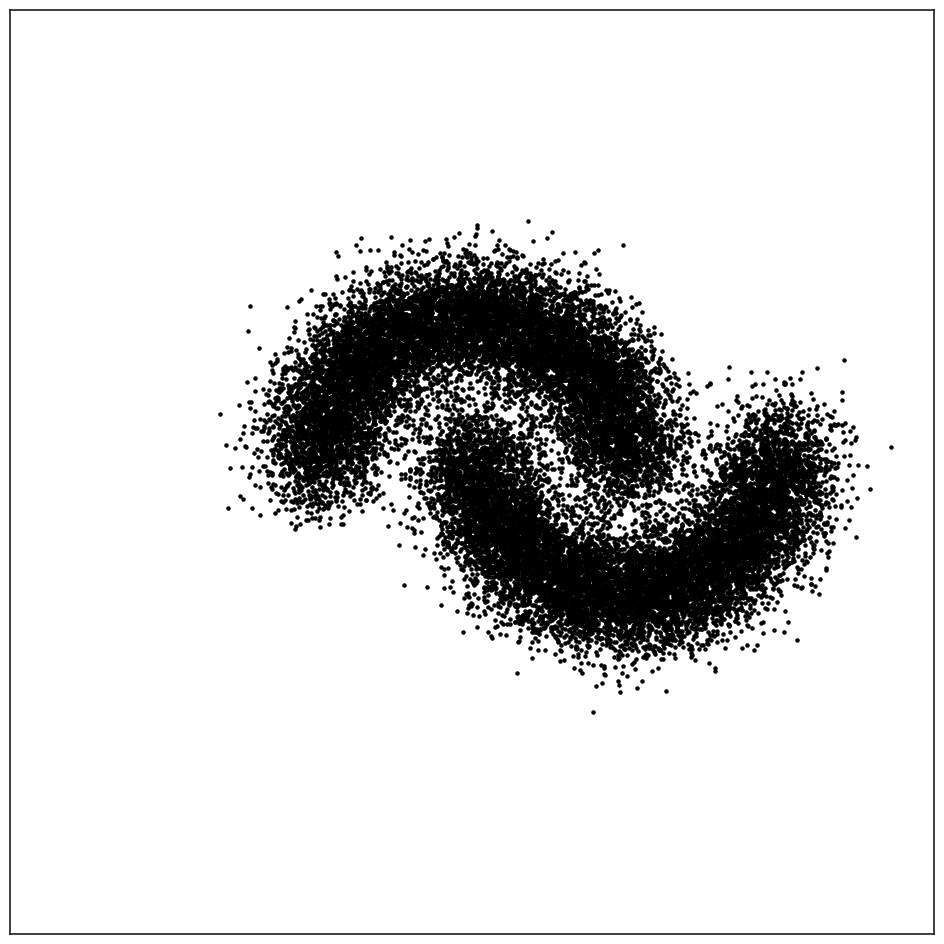

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))

# Set aspect ratio to equal to ensure the circle isn't elliptical
ax.set_aspect("equal")

ax.scatter(top_chm["x"], top_chm["y"], c="black", marker=".", s=20)
ax.scatter(bottom_chm["x"], bottom_chm["y"], c="black", marker=".", s=20)

# Set the limits of the plot
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xticks([])
ax.set_yticks([])
ax.yaxis.labelpad = 18  # adjust the value as needed
ax.yaxis.label.set_rotation(0)  # 90 degrees for vertical

plt.show()

In [6]:
bottom_data = jnp.stack(
    [jnp.ones(len(bottom_chm["x"])), bottom_chm["x"], bottom_chm["y"]]
)
top_data = jnp.stack([jnp.zeros(len(top_chm["x"])), top_chm["x"], top_chm["y"]])

In [7]:
data = jnp.hstack((top_data, bottom_data)).transpose()
data


Array([[ 0.        ,  1.0597    ,  0.18981388],
       [ 0.        ,  0.6821479 , -0.16515748],
       [ 0.        ,  1.3900204 , -0.01971286],
       ...,
       [ 1.        ,  2.0538948 ,  0.08787669],
       [ 1.        ,  2.1565962 , -0.03566776],
       [ 1.        ,  1.9037704 , -0.12333423]], dtype=float32)

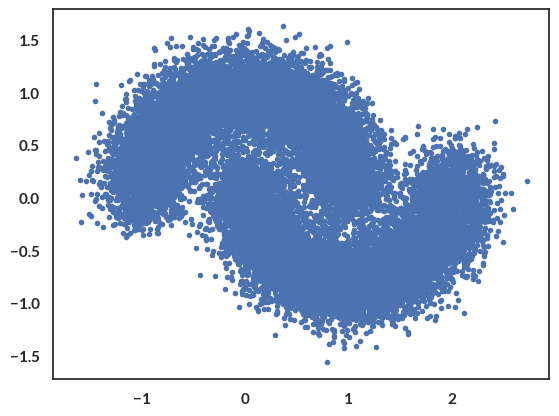

In [8]:
plt.scatter(data[:, 1], data[:, 2], marker=".")

## Model & guide

In [9]:
@genjax.gen
def model(decoder):
    latent = grasp.mv_normal_diag_reparam(jnp.zeros(10), jnp.ones(10)) @ "latent"
    label = grasp.categorical_enum(jnp.array([0.5, 0.5])) @ "label"
    obs_mean = decoder(latent, label)
    img = (
        grasp.mv_normal_diag_reparam(obs_mean, 0.01 * jnp.ones_like(obs_mean)) @ "image"
    )


@genjax.gen
def label_guide_with_aux(chm, aux_encoder, label_encoder, encoder):
    image = chm["image"]
    μ_aux, Σ_aux = aux_encoder(image)
    aux = grasp.mv_normal_diag_reparam(μ_aux, Σ_aux) @ "aux"
    logits = label_encoder(aux, image)
    label = grasp.categorical_enum(logits) @ "label"
    μ_latent, Σ_latent = encoder(aux, label, image)
    z = grasp.mv_normal_diag_reparam(μ_latent, Σ_latent) @ "latent"


@genjax.gen
def guide_with_aux(chm, aux_encoder, encoder):
    image = chm["image"]
    label = chm["label"]
    μ_aux, Σ_aux = aux_encoder(image)
    aux = grasp.mv_normal_diag_reparam(μ_aux, Σ_aux) @ "aux"
    μ_latent, Σ_latent = encoder(aux, label, image)
    z = grasp.mv_normal_diag_reparam(μ_latent, Σ_latent) @ "latent"


@genjax.gen
def meta_guide(guide_chm, data_chm, aux_decoder):
    img = data_chm["image"]
    label = data_chm["label"]
    latent = guide_chm["latent"]
    aux_mean, aux_var = aux_decoder(latent, img, label)
    _ = grasp.mv_normal_diag_reparam(aux_mean, aux_var) @ "aux"


@genjax.gen
def meta_label_guide(guide_chm, data_chm, aux_decoder):
    img = data_chm["image"]
    label = guide_chm["label"]
    latent = guide_chm["latent"]
    aux_mean, aux_var = aux_decoder(latent, img, label)
    _ = grasp.mv_normal_diag_reparam(aux_mean, aux_var) @ "aux"


guide = grasp.marginal(
    genjax.select("latent"),
    guide_with_aux,
    lambda data_chm, aux_decoder: grasp.sir(5, meta_guide, (data_chm, aux_decoder)),
)

label_guide = grasp.marginal(
    genjax.select("label", "latent"),
    label_guide_with_aux,
    lambda data_chm, aux_decoder: grasp.sir(
        5, meta_label_guide, (data_chm, aux_decoder)
    ),
)


###############
# Deep layers #
###############


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(11, 20, key=key1)
        dense_2 = eqx.nn.Linear(20, 2, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, latent, label):
        v = jnp.concatenate([latent, jnp.expand_dims(label, axis=0)])
        v = self.dense_1(v)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:2]


# Create aux decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)


@dataclass
class AUXDecoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(13, 20, key=key1)
        dense_2 = eqx.nn.Linear(20, 20, key=key2)
        return AUXDecoder(dense_1, dense_2)

    def __call__(self, latent, img, label):
        v = jnp.concatenate([latent, img, jnp.expand_dims(label, axis=0)])
        v = self.dense_1(v)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:10], jax.nn.softplus(v[10:])


# Create aux decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
aux_decoder = AUXDecoder.new(sub_key1, sub_key2)


@dataclass
class AUXEncoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(2, 20, key=key1)
        dense_2 = eqx.nn.Linear(20, 20, key=key2)
        return AUXEncoder(dense_1, dense_2)

    def __call__(self, image):
        v = self.dense_1(image)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:10], jax.nn.softplus(v[10:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
aux_encoder = AUXEncoder.new(sub_key1, sub_key2)


@dataclass
class LabelEncoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(12, 20, key=key1)
        dense_2 = eqx.nn.Linear(20, 2, key=key2)
        return LabelEncoder(dense_1, dense_2)

    def __call__(self, aux, image):
        v = jnp.concatenate([aux, image])
        v = self.dense_1(v)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.softmax(v)


key, sub_key1, sub_key2 = jax.random.split(key, 3)
label_encoder = LabelEncoder.new(sub_key1, sub_key2)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(13, 20, key=key1)
        dense_2 = eqx.nn.Linear(20, 20, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, aux, label, img):
        v = jnp.concatenate([aux, jnp.expand_dims(label, axis=0), img])
        v = self.dense_1(v)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:10], jax.nn.softplus(v[10:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)

## Training

### Testing grads

In [10]:
# Test grads
chm = genjax.choice_map({"image": jnp.array([0.1, 1.0])})
objective = grasp.elbo(model, label_guide, chm)
jitted = jax.jit(objective.value_and_grad_estimate)
loss, grads = jitted(
    key,
    (
        (decoder,),
        (
            (chm, aux_encoder, label_encoder, encoder),
            (chm, aux_decoder),
        ),
    ),
)
grads


(
    (
        Decoder(
            dense_1=Linear(
  weight=f32[20,11],
  bias=f32[20],
  in_features=11,
  out_features=20,
  use_bias=True
),
            dense_2=Linear(
  weight=f32[2,20],
  bias=f32[2],
  in_features=20,
  out_features=2,
  use_bias=True
)
        ),
    ),
    (
        (
            HierarchicalChoiceMap(
                trie=Trie(
                    inner={
                        'image': ValueChoiceMap(value=Array([ 311.48547, -926.3283 ], dtype=float32))
                    }
                )
            ),
            AUXEncoder(
                dense_1=Linear(
  weight=f32[20,2],
  bias=f32[20],
  in_features=2,
  out_features=20,
  use_bias=True
),
                dense_2=Linear(
  weight=f32[20,20],
  bias=f32[20],
  in_features=20,
  out_features=20,
  use_bias=True
)
            ),
            LabelEncoder(
                dense_1=Linear(
  weight=f32[20,12],
  bias=f32[20],
  in_features=12,
  out_features=20,
  use_bias=True
),
                de

In [11]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init():
        return (
            num_batch,
            np.random.permutation(data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [12]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 200


def label_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def _grads(key, params, data):
            (
                decoder,
                aux_encoder,
                encoder,
                aux_decoder,
            ) = params

            label = data[0]
            image = data[1:]
            data = genjax.choice_map({"image": image, "label": label})
            objective = grasp.elbo(model, guide, data)
            loss, params_grads = objective.value_and_grad_estimate(
                key,
                (
                    (decoder,),
                    (
                        (data, aux_encoder, encoder),
                        (data, aux_decoder),
                    ),
                ),
            )

            (
                (decoder_grads,),
                (
                    (_, aux_encoder_grads, encoder_grads),
                    (_, aux_decoder_grads),
                ),
            ) = params_grads
            return loss, (
                decoder_grads,
                aux_encoder_grads,
                encoder_grads,
                aux_decoder_grads,
            )

        sub_keys = jax.random.split(key, len(data_batch))
        loss, params_grads = jax.vmap(_grads, in_axes=(0, None, 0))(
            sub_keys, params, data_batch
        )

        params_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            params_grads,
        )
        updates, opt_state = optimiser.update(params_grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
labeled_updater = label_update(model, guide, adam)
train_init, train_fetch = data_loader(data, batch_size)
num_batch, train_idx = train_init()


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)
        params, opt_state, loss = labeled_updater(updater_key, params, opt_state, batch)
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
    )
    return params, opt_state, losses


# Train.
key = jax.random.PRNGKey(314159)

labeled_params = (
    decoder,
    aux_encoder,
    encoder,
    aux_decoder,
)

opt_state = adam.init(labeled_params)
t0 = time.perf_counter()
losses = []
accuracy = []
for i in range(0, num_epochs):
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init()
    params, opt_state, loss = epoch_train(opt_state, labeled_params, sub_key, train_idx)
    elapsed = time.perf_counter() - t0
    if i % 50 == 0:
        print(f"Epoch={i}, elapsed={elapsed:.2f}, loss={jnp.mean(loss):.2f}")

Epoch=0, elapsed=2.26, loss=-5951.97
Epoch=50, elapsed=7.28, loss=-6028.50
Epoch=100, elapsed=12.26, loss=-6028.54
Epoch=150, elapsed=17.24, loss=-6051.94


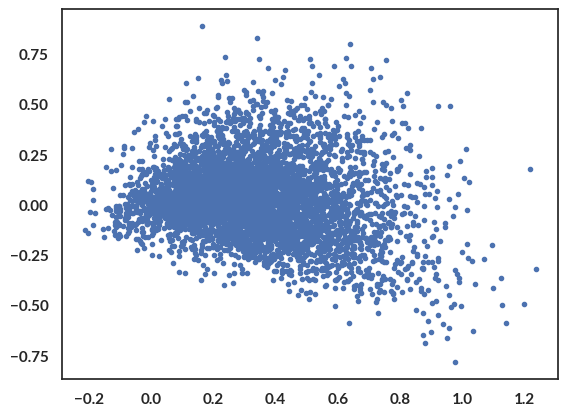

In [16]:
trained_decoder, *_ = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(key, 5000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (decoder,))
v = jax.vmap(trained_decoder)(tr["latent"], tr["label"])
x = v[:, 0]
y = v[:, 1]
plt.scatter(x, y, marker=".")

In [14]:
batch_size = 64
learning_rate = 1.0e-4
num_epochs = 200


def unsupervised_update(model, guide, optimiser):
    def batch_updater(key, params, opt_state, data_batch):
        def _grads(key, params, data):
            (
                decoder,
                aux_encoder,
                label_encoder,
                encoder,
                aux_decoder,
            ) = params

            image = data[1:]
            data = genjax.choice_map({"image": image})
            objective = grasp.elbo(model, guide, data)
            loss, params_grads = objective.value_and_grad_estimate(
                key,
                (
                    (decoder,),
                    (
                        (data, aux_encoder, label_encoder, encoder),
                        (data, aux_decoder),
                    ),
                ),
            )

            (
                (decoder_grads,),
                (
                    (_, aux_encoder_grads, label_encoder_grads, encoder_grads),
                    (_, aux_decoder_grads),
                ),
            ) = params_grads
            return loss, (
                decoder_grads,
                aux_encoder_grads,
                label_encoder_grads,
                encoder_grads,
                aux_decoder_grads,
            )

        sub_keys = jax.random.split(key, len(data_batch))
        loss, params_grads = jax.vmap(_grads, in_axes=(0, None, 0))(
            sub_keys, params, data_batch
        )

        params_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0),
            params_grads,
        )
        updates, opt_state = optimiser.update(params_grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss = jnp.mean(loss)
        return params, opt_state, loss

    return batch_updater


adam = optax.adam(learning_rate)
unsupervised_updater = unsupervised_update(model, label_guide, adam)
train_init, train_fetch = data_loader(data, batch_size)
num_batch, train_idx = train_init()


@jax.jit
def epoch_train(opt_state, params, key, train_idx):
    def body_fn(carry, xs):
        idx, params, opt_state, loss = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)
        params, opt_state, loss = unsupervised_updater(
            updater_key, params, opt_state, batch
        )
        idx += 1
        return (idx, params, opt_state, loss), loss

    idx = 0
    (_, params, opt_state, _), losses = jax.lax.scan(
        body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
    )
    return params, opt_state, losses


# Train.
key = jax.random.PRNGKey(314159)

unsupervised_params = (
    decoder,
    aux_encoder,
    label_encoder,
    encoder,
    aux_decoder,
)

opt_state = adam.init(unsupervised_params)
t0 = time.perf_counter()
losses = []
accuracy = []
for i in range(0, num_epochs):
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init()
    params, opt_state, loss = epoch_train(
        opt_state, unsupervised_params, sub_key, train_idx
    )
    elapsed = time.perf_counter() - t0
    if i % 50 == 0:
        print(f"Epoch={i}, elapsed={elapsed:.2f}, loss={jnp.mean(loss):.2f}")

Epoch=0, elapsed=2.76, loss=-6450.12
Epoch=50, elapsed=9.02, loss=-6470.33
Epoch=100, elapsed=15.27, loss=-6459.18
Epoch=150, elapsed=21.52, loss=-6453.59


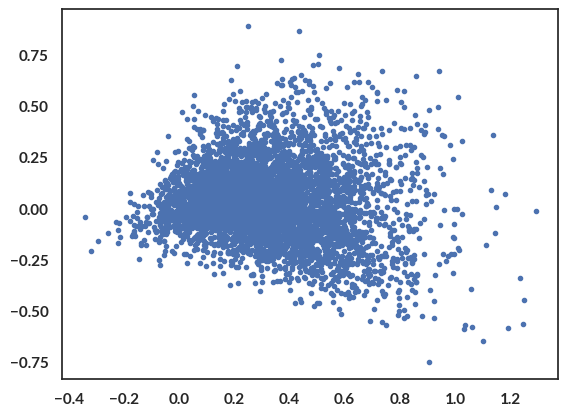

In [15]:
trained_decoder, *_ = params
key, sub_key = jax.random.split(key)
sub_keys = jax.random.split(key, 5000)
tr = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))(sub_keys, (decoder,))
v = jax.vmap(trained_decoder)(tr["latent"], tr["label"])
x = v[:, 0]
y = v[:, 1]
plt.scatter(x, y, marker=".")